In [17]:
from dotenv import load_dotenv
load_dotenv()

True

In [18]:
from typing import Annotated, Literal, TypedDict

from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

In [19]:
llm = init_chat_model("openai:gpt-4o-mini")

In [20]:
class State(TypedDict): # Messages have the type "list". The 'add_messages' function # in the annotation defines how this state key should be updated # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [21]:
# Define the tools for the agent to use
@tool
def search(query: str) -> str:
    """Call to surf the web.""" # This is a placeholder, but don't tell the LLM that...
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

tools = [search]

In [22]:
tool_node = ToolNode(tools)
model = llm.bind_tools(tools)

# Define the function that determines whether to continue or not
def should_continue(state: State) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1] # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools" # Otherwise, we stop (reply to the user)
    return END

# Define the function that calls the model
def call_model(state: State):
    messages = state['messages']
    response = model.invoke(messages) # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [23]:
# Define a new graph
workflow = StateGraph(State)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as 'agent'
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges( # First, we define the start node. We use 'agent'. # This means these are the edges taken after the 'agent' node is called.
    "agent", # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from 'tools' to 'agent'.
# This means that after 'tools' is called, 'agent' node is called next.
workflow.add_edge("tools", 'agent')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable.
# Note that we're (optionally) passing the memory when compiling the graph
app = workflow.compile()

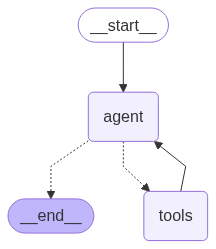

In [24]:
app

In [26]:
import os

In [36]:
from langsmith import Client

questions = [
    "what's the weather in sf",
    "whats the weather in san fran",
    "whats the weather in tangier"
]
answers = [
    "It's 60 degrees and foggy.",
    "It's 60 degrees and foggy.",
    "It's 90 degrees and sunny.",
]

ls_client = Client(api_key=os.environ.get("LANGSMITH_API_KEY"))

dataset = ls_client.create_dataset(
    dataset_name="weatheragent",
    inputs=[{"question": q} for q in questions],
    outputs=[{"answers": a} for a in answers],
)

TypeError: Client.create_dataset() got an unexpected keyword argument 'inputs'

In [34]:
dataset.dict()

{'name': 'weather agent',
 'description': None,
 'data_type': <DataType.kv: 'kv'>,
 'id': UUID('9cbddb44-3e85-4e67-962f-37221cd5e539'),
 'created_at': datetime.datetime(2025, 8, 25, 10, 25, 14, 396220, tzinfo=datetime.timezone.utc),
 'modified_at': datetime.datetime(2025, 8, 25, 10, 25, 14, 396220, tzinfo=datetime.timezone.utc),
 'example_count': 0,
 'session_count': 0,
 'last_session_start_time': None,
 'inputs_schema': None,
 'outputs_schema': None,
 'transformations': None}

In [14]:
judge_llm = init_chat_model("gpt-4o-mini")

async def correct(outputs: dict, reference_outputs: dict) -> bool:
    instructions = (
        "Given an actual answer and an expected answer, determine whether"
        " the actual answer contains all of the information in the"
        " expected answer. Respond with 'CORRECT' if the actual answer"
        " does contain all of the expected information and 'INCORRECT'"
        " otherwise. Do not include anything else in your response."
    )
    # Our graph outputs a State dictionary, which in this case means
    # we'll have a 'messages' key and the final message should
    # be our actual answer.
    actual_answer = outputs["messages"][-1].content
    expected_answer = reference_outputs["answer"]
    user_msg = (
        f"ACTUAL ANSWER: {actual_answer}"
        f"\n\nEXPECTED ANSWER: {expected_answer}"
    )
    response = await judge_llm.ainvoke(
        [
            {"role": "system", "content": instructions},
            {"role": "user", "content": user_msg}
        ]
    )
    return response.content.upper() == "CORRECT"

In [37]:
from langsmith import aevaluate

def example_to_state(inputs: dict) -> dict:
  return {"messages": [{"role": "user", "content": inputs['question']}]}

# We use LCEL declarative syntax here.
# Remember that langgraph graphs are also langchain runnables.
target = example_to_state | app

experiment_results = await aevaluate(
    target,
    data="weather agent",
    evaluators=[correct],
    max_concurrency=4,  # optional
    experiment_prefix="gpt-4o-mini",  # optional
)

LangSmithAuthError: Authentication failed for /datasets. HTTPError('401 Client Error: Unauthorized for url: https://api.smith.langchain.com/datasets?limit=1&name=weather+agent', '{"detail":"Invalid token"}')